In [1]:
r"""
This tutorial is focused on the magnon-magnon mechanism of magnon damping

In this version we calculate the damping in a monolayer of CrSBr
while using a small K-grid

Note that the calculation time for magnon-magnon damping
depends (in some parts of the calculations) on the grid size N
as N^4. 

The progress of the calculation can be viewed in the Log-file
"""

import numpy as np
import matplotlib.pyplot as plt


import MagnoFallas as mfal

In [2]:
## the following line shoud contain a valid path to the tutorial data
TutorialData = '..//TutorialData'

file1 = TutorialData + '//CrSBr//exchange.out'
SH0 = mfal.ReadTB2J(file1, 1.5)
# 1.5 = 3/2 - Cr spin in CrSBr

In [3]:
# The available data for CrSBr includes one inconsistancy in the notation: the y-axis for coordinates
# is considered as z-axis for spin
# the following procedure resolve such an inconsistency
def correctCrSBt(SH0):
    sv0 = np.array((0,1.5,0))
    for at in SH0.magnetic_atoms:
        at.spin_vector = sv0
    
    SHi = mfal.qut.make_FerroHam(SH0)
    for at in SHi.magnetic_atoms:
        at.spin_vector = sv0
    
    return SHi

SH = correctCrSBt(SH0)

In [4]:
#### we define the parameters of the calculations
Ng = 8   ### K-grid size in each direction (for the "master" K-grid for magnon vector k1)
rm = 0.15  ### shows that only 0.25 of the K-space in all the direction
           ### would be covered by the k-grid
           ### this is usefull to avoid costly calculation for large magnon k-vectors, which have
           ### a minor effect on the damping
Nac = 6   ### this value would be used for secondary grids, dinamically calculated for the magnon wavevector k2
B0 = 0.2  ## external magnetic field [T]
R0 = 8  ### cutoff for short-range/long-range dipole-dipole interaciton [angstr]

In [5]:
## We creathe the mfal.damping4M object controlling the calculations
dampMC = mfal.damping4M(SH, Ng, Ng, rKxM = rm, rKyM = rm, dim=2,  
        roles = mfal.roles['MagnonMC'],  Name = 'damping_CrSBr_4M_MC',
        B=B0, NKXac=Nac, NKYac=Nac, includeSRDD=True,  LRdd=True, R0=R0)
#
# the parameters here are:
# SH - spin Hamiltonian of the problem
# Ng, Ng - the size of Kgrid (for 3D the "third" size of K-grid for z-direction should also be set)
# dim=2 - shows that we study a 2D material
# roles = mfal.roles['MagnonMC'] --- shows that we study magnon-conserving processes (the only processes possible in the toy model)
# Name -- name of the process. Used for the Log and saving files
# B - external magnetic field [T]
# NKXac=Nac, NKYac=Nac - the parameters controlling "second" grid for magnon wavevector k2
# includeSRDD=True - shows that the short-range dipole-dipole interaciton should be automatically included into the Hamiltonian
# LRdd=True - shows that long-range dipole-dipole interaction should be taken into account during the calculations
# R0 - cutoff for short-range/long-range dipole-dipole interaciton [angstr]

In [6]:
dampMC.GenScatSet()
### Here we identify the "scattering events"

dampMC.InitScater()
### Here calculate the "real" momenta of the participating magnons, integrals of delta-functions and matrix elements

## both the processes must be finished before the relaxation can be calculated
## nevertheless, the scatterings can be saved before the initalization to divided the process into the parts

In [7]:
dampMC.saveScatterings()
#The scattering events can be loaded later with dampMC.loadScatterings()

In [8]:
##### THe version of the calculations for the Non Magnon Conserving processes
# The most important difference is 
# roles = mfal.roles['MagnonNMC']
# also for the NMC processes it is more correct to use the same K-grid for all the wavevectors
# this is controlled by acuRegime=False
# parameters NKXac and NKYac not required
dampNMC = mfal.damping4M(SH, Ng, Ng, rKxM = rm, rKyM = rm, dim=2,  
        roles = mfal.roles['MagnonNMC'],  Name = 'damping_CrSBr_4M_NMC',
        B=B0, acuRegime=False, includeSRDD=True,  LRdd=True, R0=R0)

dampNMC.GenScatSet()
dampNMC.InitScater()
dampNMC.saveScatterings()

In [9]:
## here we select temperatures for the calculation of damping and do the calculation itself
## with the scattering events initialized, this part is usually fast
tt = np.linspace(0.1, 50, 100)
alpsMC = np.array([dampMC.alpha(t) for t in tt])
alpsNMC = np.array([dampNMC.alpha(t) for t in tt])

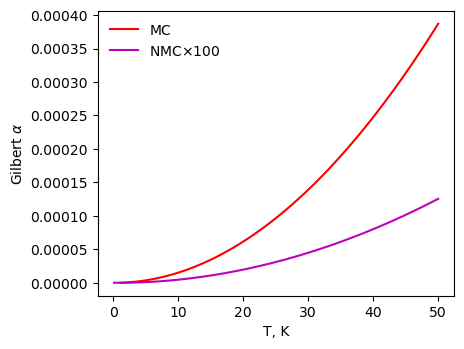

In [10]:
# Here we plot the temperature dependence of the damping
plt.figure(figsize=(4.6,3.7))
plt.plot(tt,alpsMC,'r-', label='MC')
plt.plot(tt,alpsNMC*100,'m-', label=r'NMC$\times 100$')

plt.legend(frameon=False)

plt.xlabel('T, K')
plt.ylabel(r'Gilbert $\alpha$')
plt.savefig('CrSBr-magnon-damping.png', bbox_inches='tight')

plt.show()

In [11]:
### to asess the parameters of the calculations it is useful
### to calculate the map of the contributions of different
### wavevectros k_1 to the damping

T1 = 50
axis, Contr =  dampMC.alphaContrib(T1)

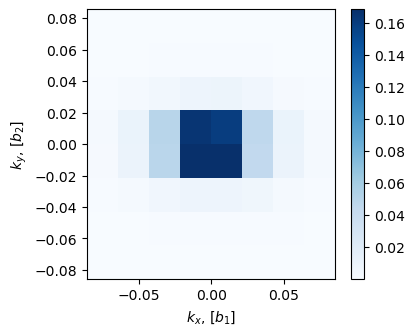

In [12]:
### Here we calculate the total contributions of all the branches and show the result
plt.figure(figsize=(4.0,3.5))
plt.pcolormesh(axis[0], axis[1], np.transpose(Contr), cmap='Blues' )
plt.xlabel(r'$k_x$, $[b_1]$')
plt.ylabel(r'$k_y$, $[b_2]$')
plt.colorbar()

plt.savefig('CrSBr-magnon-contribution-MC.png', bbox_inches='tight')

plt.show()


In [13]:
## A similar calculation for NMC processes
T1 = 50
axis2, ContrNMC =  dampNMC.alphaContrib(T1)

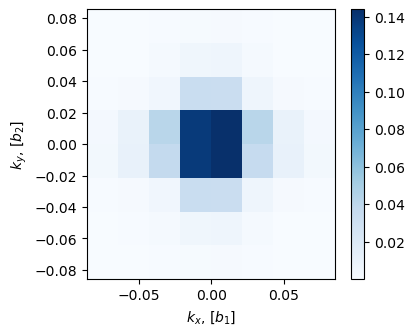

In [14]:
### Here we calculate the total contributions of all the branches and show the result
plt.figure(figsize=(4.0,3.5))
plt.pcolormesh(axis2[0], axis2[1], np.transpose(ContrNMC), cmap='Blues' )
plt.xlabel(r'$k_x$, $[b_1]$')
plt.ylabel(r'$k_y$, $[b_2]$')
plt.colorbar()

plt.savefig('CrSBr-magnon-contribution-NMC.png', bbox_inches='tight')

plt.show()
